In [21]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import keras
import keras.backend as Kback
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

model_path = 'RNN_regression_PCA_FD2.h5'

import random
random.seed(123)


In [22]:
from math import e

In [23]:
#######
#Data ingestion & processing
######

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD002.txt", delimiter = ' ')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD002.txt", delimiter = ' ')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD002.txt")
RUL_real = RUL_test

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


#We need to identify every operating mode and normalize it 

kmeans = KMeans(n_clusters = 6, random_state = 0).fit(train_df[['OP1','OP2','OP3']])
train_df['OP_Condition'] = kmeans.labels_

test_df['OP_Condition'] = kmeans.predict(test_df[['OP1','OP2','OP3']])

###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])

scaler0 = StandardScaler()
train_df.loc[train_df['OP_Condition']==0, cols_normalize] = scaler0.fit_transform(train_df.loc[train_df['OP_Condition']==0, cols_normalize])

scaler1 = StandardScaler()
train_df.loc[train_df['OP_Condition']==1, cols_normalize] = scaler1.fit_transform(train_df.loc[train_df['OP_Condition']==1, cols_normalize])

scaler2 = StandardScaler()
train_df.loc[train_df['OP_Condition']==2, cols_normalize] = scaler2.fit_transform(train_df.loc[train_df['OP_Condition']==2, cols_normalize])

scaler3 = StandardScaler()
train_df.loc[train_df['OP_Condition']==3, cols_normalize] = scaler3.fit_transform(train_df.loc[train_df['OP_Condition']==3, cols_normalize])

scaler4 = StandardScaler()
train_df.loc[train_df['OP_Condition']==4, cols_normalize] = scaler4.fit_transform(train_df.loc[train_df['OP_Condition']==4, cols_normalize])

scaler5 = StandardScaler()
train_df.loc[train_df['OP_Condition']==5, cols_normalize] = scaler5.fit_transform(train_df.loc[train_df['OP_Condition']==5, cols_normalize])

#norm = Normalizer()

#train_df.loc[:,cols_normalize] = norm.fit_transform(train_df.loc[:,cols_normalize])
train_normalized = train_df

scaled_train = train_df[cols_normalize]

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(scaled_train)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)




In [24]:
def complete (test_df, seq_length):

    for i in test_df['Unit']:

        test = test_df[test_df['Unit']==i]

        if (test['Cycle'].max()<seq_length):

            print("He entrado en ", i)

            n_cycles = seq_length - test['Cycle'].max()

            new_values = np.zeros((n_cycles.astype(int),test_df.shape[1]))
            new_values[:,2:] = test.iloc[:,2:].mean(axis = 0).to_numpy()
            new_values[:,0] = i
            new_values[:,1] = range(test['Cycle'].max().astype(int)+1, seq_length+1)

            new_values = pd.DataFrame(new_values, columns = test_df.columns)

            test = pd.concat([test,new_values]).reset_index()

            test = test.drop(test.columns[0],axis=1)

            #print(test.head())

            test_df = pd.concat([test_df[test_df['Unit']<i],test,test_df[test_df['Unit']>i]]).reset_index()

            test_df = test_df.drop(test_df.columns[0],axis = 1)


    return test_df


In [25]:
###TEST DATA SET###


#Normalize data
test_df['Cycle_norm'] = test_df['Cycle']
test_df['Cycle_norm'] = test_df['Cycle']

test_df.loc[test_df['OP_Condition']==0, cols_normalize] = scaler0.transform(test_df.loc[test_df['OP_Condition']==0, cols_normalize])

test_df.loc[test_df['OP_Condition']==1, cols_normalize] = scaler1.transform(test_df.loc[test_df['OP_Condition']==1, cols_normalize])

test_df.loc[test_df['OP_Condition']==2, cols_normalize] = scaler2.transform(test_df.loc[test_df['OP_Condition']==2, cols_normalize])

test_df.loc[test_df['OP_Condition']==3, cols_normalize] = scaler3.transform(test_df.loc[test_df['OP_Condition']==3, cols_normalize])

test_df.loc[test_df['OP_Condition']==4, cols_normalize] = scaler4.transform(test_df.loc[test_df['OP_Condition']==4, cols_normalize])

test_df.loc[test_df['OP_Condition']==5, cols_normalize] = scaler5.transform(test_df.loc[test_df['OP_Condition']==5, cols_normalize])

#test_df.loc[:,cols_normalize] = norm.

sequence_length = 50

test_df = complete(test_df, sequence_length+1)

norm_test_df = test_df[cols_normalize]

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)






He entrado en  18
He entrado en  23
He entrado en  28
He entrado en  37
He entrado en  51
He entrado en  59
He entrado en  83
He entrado en  101
He entrado en  113
He entrado en  122
He entrado en  165
He entrado en  194
He entrado en  201
He entrado en  204
He entrado en  205
He entrado en  217
He entrado en  218
He entrado en  223
He entrado en  224
He entrado en  228
He entrado en  233
He entrado en  240
He entrado en  241
He entrado en  243
He entrado en  244
He entrado en  249


In [ ]:
test_df.head()

In [ ]:
seq_array.shape

In [26]:
#####
#Data formatting#
####

# Data will be input into the RNN in windows with a certain size
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

sequence_cols = list(train_df.columns[2:-5].values)
#sequence_cols.extend(["Cycle_norm"])

#val=list(gen_sequence(train_df[train_df['Unit']==1], sequence_length, sequence_cols))

seq_gen = (list(gen_sequence(train_df[train_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in train_df['Unit'].unique())


# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['Unit']==id], sequence_length, ['RUL']) 
             for id in train_df['Unit'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(40759, 50, 17)


(40759, 1)

In [27]:
label_array[label_array >185] = 185

print(label_array[90:250])

[[  8.]
 [  7.]
 [  6.]
 [  5.]
 [  4.]
 [  3.]
 [  2.]
 [  1.]
 [  0.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [184.]
 [183.]
 [182.]
 [181.]
 [180.]
 [179.]
 [178.]
 [177.]
 [176.]
 [175.]
 [174.]
 [173.]
 [172.]
 [171.]
 [170.]
 [169.]
 [168.]
 [167.]
 [166.]
 [165.]
 [164.]
 [163.]
 [162.]
 [161.]
 [160.]
 [159.]
 [158.]
 [157.]
 [156.]
 [155.]
 [154.]
 [153.]
 [152.]
 [151.]
 [150.]
 [149.]
 [148.]
 [147.]
 [146.]
 [145.]
 [144.]
 [143.]
 [142.]
 [141.]
 [140.]
 [139.]
 [138.]
 [137.]
 [136.]
 [135.]
 [134.]
 [133.]
 [132.]
 [131.]
 [130.]
 [129.]
 [128.]
 [127.]
 [126.]
 [125.]
 [124.]
 [123.]
 [122.]
 [121.]
 [120.]
 [119.]
 [118.]
 [117.]
 [116.]
 [115.]
 [114.]
 [113.]
 [112.]
 [111.]
 [110.]
 [109.]
 [108.]
 [107.]
 [106.]
 [105.]
 [104.]
 [103.]


In [28]:
print(label_array[90:250])

[[  8.]
 [  7.]
 [  6.]
 [  5.]
 [  4.]
 [  3.]
 [  2.]
 [  1.]
 [  0.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [185.]
 [184.]
 [183.]
 [182.]
 [181.]
 [180.]
 [179.]
 [178.]
 [177.]
 [176.]
 [175.]
 [174.]
 [173.]
 [172.]
 [171.]
 [170.]
 [169.]
 [168.]
 [167.]
 [166.]
 [165.]
 [164.]
 [163.]
 [162.]
 [161.]
 [160.]
 [159.]
 [158.]
 [157.]
 [156.]
 [155.]
 [154.]
 [153.]
 [152.]
 [151.]
 [150.]
 [149.]
 [148.]
 [147.]
 [146.]
 [145.]
 [144.]
 [143.]
 [142.]
 [141.]
 [140.]
 [139.]
 [138.]
 [137.]
 [136.]
 [135.]
 [134.]
 [133.]
 [132.]
 [131.]
 [130.]
 [129.]
 [128.]
 [127.]
 [126.]
 [125.]
 [124.]
 [123.]
 [122.]
 [121.]
 [120.]
 [119.]
 [118.]
 [117.]
 [116.]
 [115.]
 [114.]
 [113.]
 [112.]
 [111.]
 [110.]
 [109.]
 [108.]
 [107.]
 [106.]
 [105.]
 [104.]
 [103.]


In [29]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    score_vec = np.zeros(len(y_true))

    for i in range(len(d)): 
        if d[i]<0:
            score_vec[i] = (e**(-d[i]/a1) - 1)
            score += score_vec[i]
        else : 
            score_vec[i] = (e**(d[i]/a2) - 1)
            score += score_vec[i]

    fig_hist = plt.figure(figsize=(10,5))
    plt.hist(score_vec, color = "#3f729a" )
    hist_data, _, _ = plt.hist(score_vec, color = "#3f729a" )
    print(hist_data)
    plt.ylabel("Frequency")
    plt.xlabel("Score")

    score_low = 0
    score_high = 0

    for i in range(len(d)):

        if score_vec[i] < 50:
            score_low += score_vec[i]
        else:
            score_high += score_vec[i]

    

    print(score_low, score_high)
    print(score_low/(score_low + score_high))

    plt.figure()
    plt.plot(range(len(y_true)),score_vec)

    return score



In [30]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

RNN_model = Sequential()
RNN_model.add(LSTM(
    input_shape = (sequence_length, nb_features),
    units = 50,
    return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = False))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(units = nb_out))
RNN_model.add(Activation("linear"))
RNN_model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mae', r2_keras])

print(RNN_model.summary())

result = RNN_model.fit(seq_array, label_array, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )
print(result.history.keys())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            13600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 25)            7600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 25)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

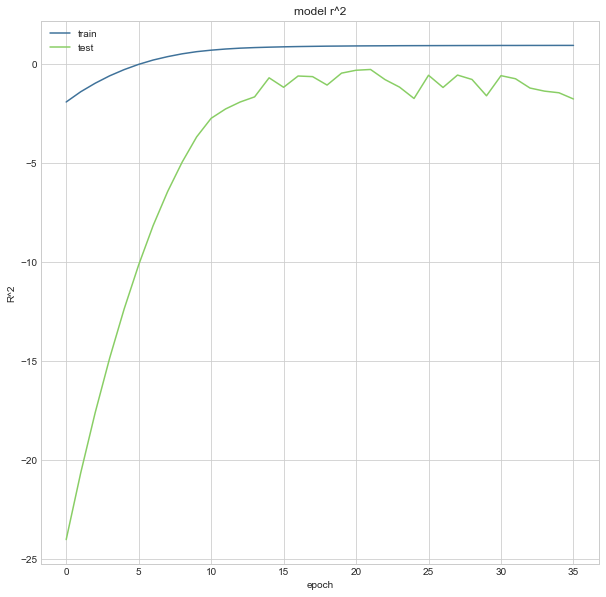

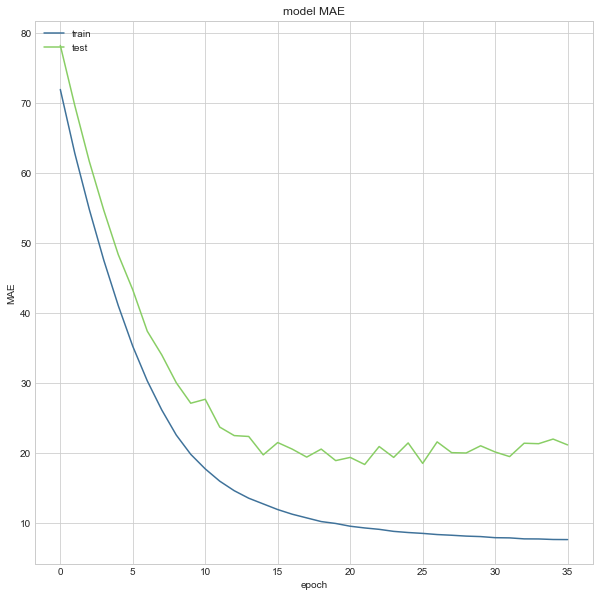

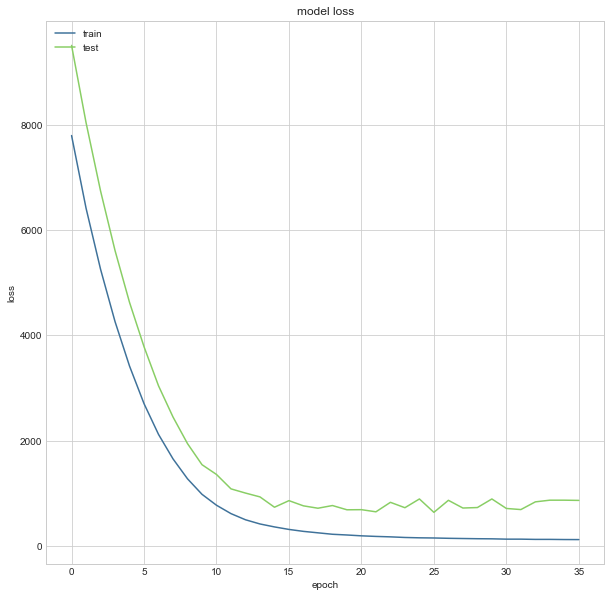

In [31]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [32]:
# training metrics
scores = RNN_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = RNN_model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)

40759/40759 [==============================] - 15s 359us/step

MAE: 6.6913628578186035

R^2: 0.9537417888641357
40759/40759 [==============================] - 15s 359us/step


In [33]:
train_df.head()

,Cycle,Unit,0,1,2,3,4,5,6,7,...,12,13,14,15,16,UL,RUL,UL_30,UL_50,UL_75
0,1,1,-1.498655,-2.455797,-0.208607,-1.691966,0.628858,1.008672,-0.059862,-0.780980,...,-0.836640,0.573051,0.649752,0.059408,1.634919,149,148,0,0,0
1,2,1,-1.014874,-2.737765,-1.129628,-0.833943,1.520716,0.193454,0.618908,-1.638737,...,0.183263,-0.034992,-0.728349,0.973158,0.607475,149,147,0,0,0
2,3,1,-1.643355,-1.954869,-0.729172,0.322237,2.463415,-0.956693,1.062625,-0.505089,...,0.514267,1.721228,0.562538,1.786229,-0.241010,149,146,0,0,0
3,4,1,-3.188583,-1.675594,-1.142278,2.368376,0.111373,0.214055,0.482405,0.006970,...,0.543419,-0.658294,-0.569857,0.115327,0.527003,149,145,0,0,0
4,5,1,-0.557356,-2.801827,-0.753086,-0.830261,0.414413,-0.315829,-1.225411,-0.895079,...,-0.185974,1.126584,0.748095,1.676923,-0.145245,149,144,0,0,0



MAE: 19.114364624023438

R^2: 0.7037720084190369


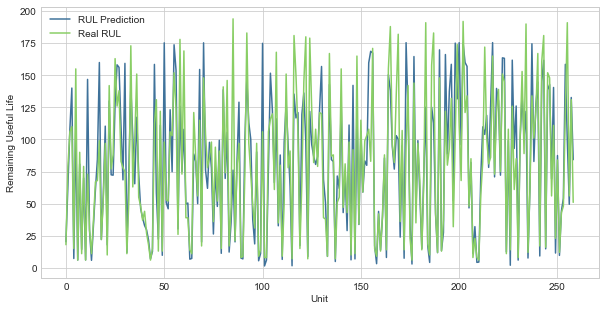

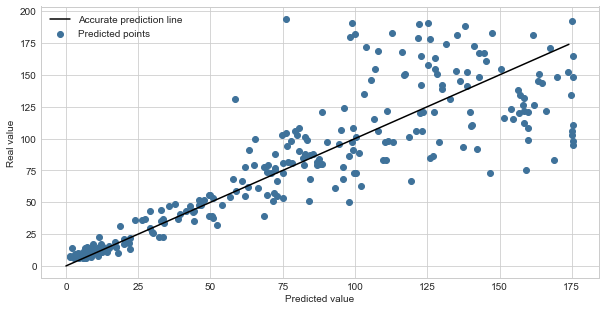

In [34]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['Unit']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['Unit'].unique() if len(test_df[test_df['Unit']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['Unit']==id]) >= sequence_length for id in test_df['Unit'].unique()]
label_array_test_last = test_df.groupby('Unit')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

[258.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
1107.0507167577744 158884.52865600586
0.006919431141925676
The computed challenge score is: S = 159991.57937276363


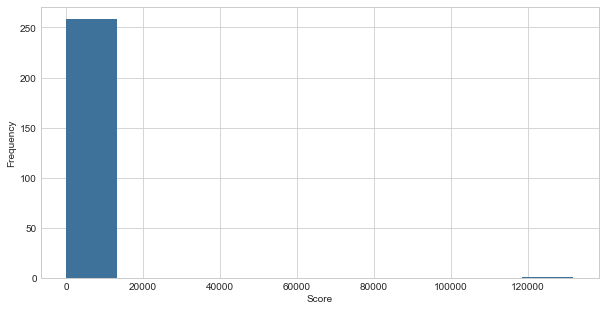

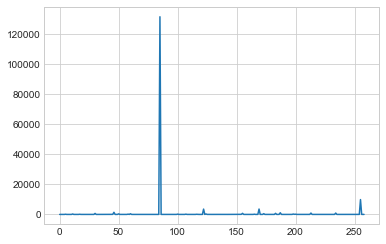

In [35]:
print("The computed challenge score is: S = {}".format(Computed_Score(y_true_test, y_pred_test)))

In [1]:
label_array[100:120]

NameError: name 'label_array' is not defined

The model score is: 159991.6305058032
The model accuracy is: 52.50965250965251
The model MAE is: 19.114362716674805
The model MSE is : 819.7706322393823
The model Mean Absolute Percentage Error (MAPE) is: 31.7510597494118
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 2244.463926955784


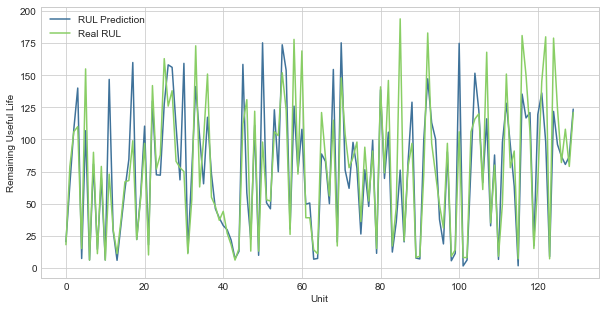

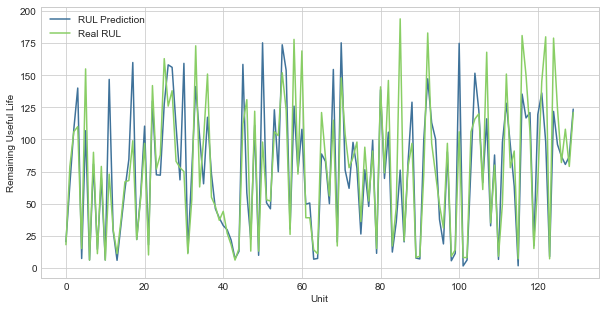

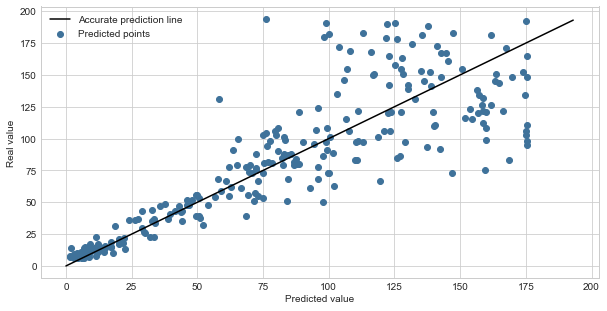

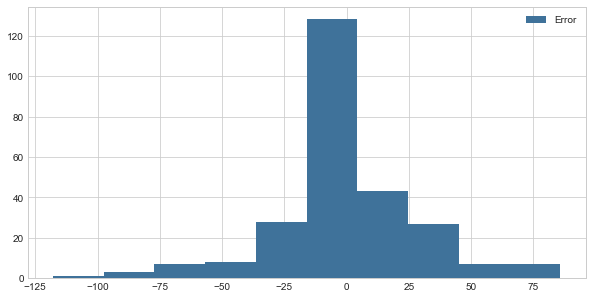

In [37]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(y_pred_test, y_true_test, test_df.groupby('Unit').max()['Cycle'].to_numpy())

In [52]:
train_predictions = RNN_model.predict(seq_array)
train_predictions.shape

(40759, 1)

In [53]:
train_df['RUL_predict'] = 0
indice_retransf = 0
for i in train_df['Unit'].unique():

    print(i)

    max_indice = train_df.loc[train_df['Unit']==i,'Cycle'].max() + indice_retransf -50

    print()

    print(train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'].shape)
    print(train_predictions[indice_retransf:max_indice,0].shape)


    train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'] = train_predictions[indice_retransf:max_indice,0]

    indice_retransf += train_df.loc[train_df['Unit']==i,'Cycle'].max() - 50

1

(99,)
(99,)
2

(219,)
(219,)
3

(156,)
(156,)
4

(185,)
(185,)
5

(104,)
(104,)
6

(125,)
(125,)
7

(124,)
(124,)
8

(101,)
(101,)
9

(149,)
(149,)
10

(134,)
(134,)
11

(221,)
(221,)
12

(199,)
(199,)
13

(177,)
(177,)
14

(143,)
(143,)
15

(159,)
(159,)
16

(104,)
(104,)
17

(130,)
(130,)
18

(159,)
(159,)
19

(113,)
(113,)
20

(104,)
(104,)
21

(139,)
(139,)
22

(142,)
(142,)
23

(161,)
(161,)
24

(141,)
(141,)
25

(155,)
(155,)
26

(137,)
(137,)
27

(126,)
(126,)
28

(150,)
(150,)
29

(101,)
(101,)
30

(116,)
(116,)
31

(293,)
(293,)
32

(231,)
(231,)
33

(145,)
(145,)
34

(155,)
(155,)
35

(146,)
(146,)
36

(153,)
(153,)
37

(160,)
(160,)
38

(127,)
(127,)
39

(164,)
(164,)
40

(143,)
(143,)
41

(212,)
(212,)
42

(171,)
(171,)
43

(161,)
(161,)
44

(155,)
(155,)
45

(101,)
(101,)
46

(151,)
(151,)
47

(196,)
(196,)
48

(189,)
(189,)
49

(118,)
(118,)
50

(172,)
(172,)
51

(243,)
(243,)
52

(124,)
(124,)
53

(98,)
(98,)
54

(149,)
(149,)
55

(109,)
(109,)
56

(113,)
(113,)
57

(

In [54]:
train_df[train_df['Unit']==unit]

,Cycle,Unit,0,1,2,3,4,5,6,7,...,14,15,16,UL,RUL,UL_30,UL_50,UL_75,RUL_tuned,RUL_predict
22610,1,112,-2.701945,1.364721,-0.554988,-0.523843,-0.663957,-0.643722,1.035557,0.013657,...,-0.557143,0.707257,0.985040,378,377,0,0,0,185,0.000000
22611,2,112,-2.749193,2.985702,-0.711819,0.020583,0.796900,1.013096,-1.156264,0.473002,...,0.573641,0.492437,-0.142661,378,376,0,0,0,185,0.000000
22612,3,112,-4.696604,1.209926,0.974217,0.375793,2.012321,-1.099901,0.138697,0.571837,...,-0.564105,1.157175,0.165342,378,375,0,0,0,185,0.000000
22613,4,112,-3.136566,2.249803,0.141987,0.258107,-1.300483,1.722998,-0.033586,-1.153996,...,-0.681687,-0.626642,1.354113,378,374,0,0,0,185,0.000000
22614,5,112,-3.995704,0.463014,1.853187,1.545533,-0.960159,-0.115274,0.301775,2.274300,...,-0.134185,0.990097,1.182869,378,373,0,0,0,185,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22983,374,112,6.434363,1.973288,-0.564084,-0.479711,-0.651307,-0.014288,0.992822,1.565596,...,0.438009,-0.933619,-1.354111,378,4,1,1,1,4,2.462017
22984,375,112,7.951807,-0.647432,1.992763,0.359876,-0.457450,-0.691331,1.510419,0.067428,...,-0.964167,-0.349333,-0.785602,378,3,1,1,1,3,2.332852
22985,376,112,8.146493,0.290169,2.087465,-0.406629,1.208447,-0.570325,1.381056,-0.705204,...,-1.554533,-0.524243,-1.000432,378,2,1,1,1,2,2.183234
22986,377,112,7.743752,1.279190,0.295965,1.251700,1.059233,0.210271,2.230949,0.787004,...,-0.297537,-1.375814,-0.279893,378,1,1,1,1,1,1.927022


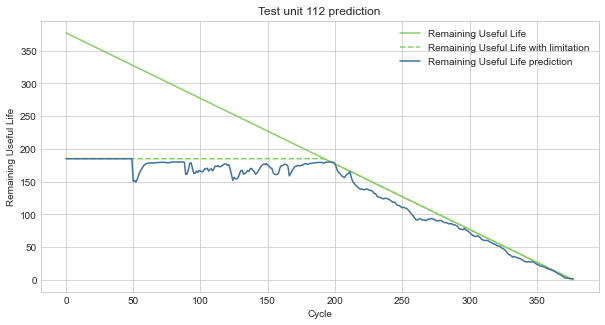

In [56]:
unit = 112

train_df['RUL_tuned']=train_df['RUL']
train_df.loc[train_df['RUL']>185,'RUL_tuned'] = 185
train_df.loc[train_df['Cycle']<=50,'RUL_predict'] = 185


plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_tuned'], color = "#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 112 prediction")

ax.legend()


In [ ]:
unit = 3

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
#ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()


In [45]:
test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_proof[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] <= 160) & (error_df['RUL'] > 140) , 'Group_RUL'] = 8
error_df.loc[(error_df['RUL'] <= 180) & (error_df['RUL'] > 160) , 'Group_RUL'] = 9
error_df.loc[(error_df['RUL'] > 180) , 'Group_RUL'] = 10

In [46]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

,Unit,Cycle,RUL,error,Group_RUL
Group,,,,,
3,157.102564,52.717949,134.871795,33.028404,7.282051
4,111.352941,71.764706,127.882353,34.954147,6.911765
5,140.894737,90.157895,130.684211,33.027603,7.052632
6,144.631579,110.789474,92.210526,25.107452,5.157895
7,121.807692,128.884615,54.230769,17.304724,3.269231
8,124.303279,185.737705,47.327869,7.537562,2.803279


In [47]:
error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,123.207547,186.339623,11.490566,3.446827,7.886792
2,112.363636,181.363636,31.818182,8.431092,7.727273
3,134.518519,156.370370,50.111111,10.080407,7.370370
4,104.142857,147.071429,72.428571,18.526096,6.678571
5,127.459459,120.540541,90.432432,22.510298,6.135135
6,131.600000,108.400000,108.280000,28.422123,5.760000
7,157.950000,74.450000,127.200000,27.063082,4.150000
8,139.047619,65.952381,149.142857,21.146584,3.761905
9,139.533333,80.133333,170.133333,39.959412,4.266667


In [42]:
error_df[error_df['Unit']==59]

,Unit,Cycle,RUL,error,Group,Group_RUL
58,59.0,51.0,178.0,52.012909,3,8


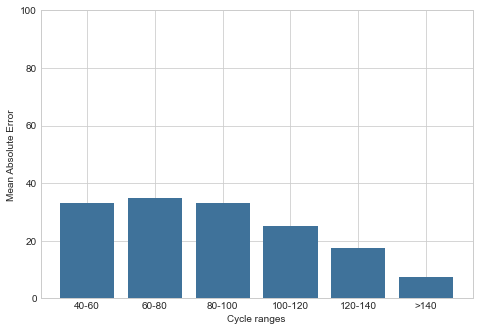

In [43]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()

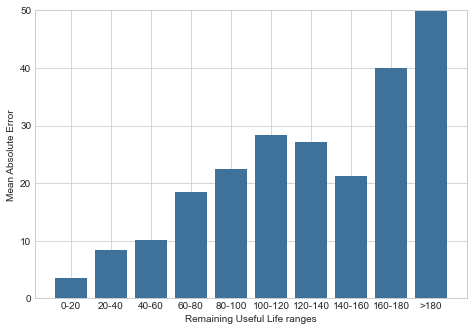

In [48]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '140-160', '160-180', '>180']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,50)
plt.show()

In [ ]:
seq_gen_testing = (list(gen_sequence(test_df[test_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in test_df['Unit'].unique())

seq_array_testing = np.concatenate(list(seq_gen_testing)).astype(np.float32)

seq_array_testing.shape

In [ ]:
test_prediction = RNN_model.predict(seq_array_testing)
test_prediction.shape

In [ ]:
test_df['RUL_predict'] = 0
indice_retransf = 0
for i in test_df['Unit'].unique():

    print(i)

    max_indice = (test_df.loc[test_df['Unit']==i,'Cycle'].max() + indice_retransf -50).astype(int)

    print(indice_retransf)
    print(max_indice)

    print(test_df.loc[(test_df['Unit']==i)&(test_df['Cycle']>50), 'RUL_predict'].shape)
    print(test_prediction[indice_retransf:max_indice,0].shape)


    test_df.loc[(test_df['Unit']==i)&(test_df['Cycle']>50), 'RUL_predict'] = test_prediction[indice_retransf:max_indice,0]

    indice_retransf += (test_df.loc[test_df['Unit']==i,'Cycle'].max() - 50).astype(int)

In [ ]:
test_prediction.shape

In [ ]:
test_df[test_df['Unit']==83][['RUL','RUL_predict']]

In [ ]:
unit = 83

for unit in test_df['Unit'].unique():
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize = (10,5))

    ax = fig.add_subplot(111)

    ax.plot(range(len(test_df[test_df['Unit']==unit])), test_df[test_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
    #ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
    ax.plot(range(len(test_df[test_df['Unit']==unit])), test_df[test_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


    ax.set_ylabel("Remaining Useful Life")
    ax.set_xlabel("Cycle")
    ax.set_title("Test unit {} prediction".format(unit))

    ax.legend()


In [ ]:
train_df[train_df['Cycle']==train_df['Cycle'].max()]

In [ ]:
test_lastcycle = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
    for id in test_df['Unit'].unique()]).reset_index(drop = True)

In [ ]:
test_lastcycle['error'] = error_df['error']

In [ ]:
test_bigerror = test_lastcycle[test_lastcycle['error']>20]


In [ ]:
fig_predict = plt.figure(figsize = (10,5))
plt.scatter(test_bigerror['RUL_predict'], test_bigerror['RUL'], c = test_bigerror['Cycle'], cmap = 'autumn')
plt.plot(range(test_bigerror['RUL_predict'].max().astype(int)),range(test_bigerror['RUL_predict'].max().astype(int)), color = "black")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.legend(['Accurate prediction line', 'Predicted points'])
plt.colorbar()
plt.show()

In [ ]:
plt.hist(test_lastcycle['RUL'])
plt.show()